In [4]:
import psycopg2
import requests
import nbimporter
import datetime
import numpy as np
import matplotlib.pyplot as plt
import Init_database as indb

Importing Jupyter notebook from Init_database.ipynb


In [297]:
db_name="db_teld"
user_name="postgres"
password = "postgres"
host="169.229.157.40"
port="5432"
conn = indb.init_db(db_name, user_name, password, host, port)

In [6]:
try:
    cur = conn.cursor()
    stmt1 = "select ST_AsText(location) from tbl_app_eachstations"
    cur.execute(stmt1)
    station_loc1 = cur.fetchall()
    stmt2 = "select ST_X(location), ST_Y(location) from tbl_app_eachstations"
    cur.execute(stmt2)
    station_loc2 = cur.fetchall()
    cur.close()
except psycopg2.Error as e:
    print(e)
print(station_loc1[0])
print(station_loc2[0])

('POINT(116.26327 39.863907)',)
(116.26327, 39.863907)


In [155]:
# #------- Request stationid which has user activities from db -------#
try:
    cur = conn.cursor()
    cur.execute("select distinct stationid from tbl_app_useractivity;")
    stationWithAct_list = cur.fetchall()
    cur.close()
except psycopg2.Error as e:
    print(e)
print("Number of stations with user activites: ", len(stationWithAct_list))
# #------- Request pilecode from db for states -------#
# staid_list = []
# for staid in stationWithAct_list:
#     staid_list.append(staid[0])
try:
    cur = conn.cursor()
#     sta_list = ['33a3c031-0a3a-417d-ba1b-53549bb08dc2']
    sta_list = ['2b3a35d4-cb94-4b8f-a47a-bbb054754066', '1d02640a-7f14-4fc3-baaf-60754a38fff7',
                'ac6cb946-5fff-491b-859e-55cc5f701657', 'dd4a3ddc-e1b0-4e2e-b7ca-faef627f4e66',
                'b134a159-16bd-4f5d-af1b-cd42599a3bab', '33a3c031-0a3a-417d-ba1b-53549bb08dc2', 
                'e4758edb-1183-4c51-887b-a52ca7abef3d', '13bdab71-110b-4448-a3c4-5c3113183546']
    #1. beijing hangkong jingmi jixie yanjiusuo chongdianzhan --'2b3a35d4-cb94-4b8f-a47a-bbb054754066',
    #2. beijing xijiao bingguan chongdianzhan -- '1d02640a-7f14-4fc3-baaf-60754a38fff7
    #3. beijing yangguanglicheng jiudian chongdianzhan --'ac6cb946-5fff-491b-859e-55cc5f701657',
    #4. beijing rongtao gongsi chongdianzhan -- '32d317a9-3d0c-4458-8357-89a2b3b1cf94'
    #5. beijing huairou qu yanshui lu -- 'dd4a3ddc-e1b0-4e2e-b7ca-faef627f4e66'
    
    #6. shenzhen hengjiang dasha chongdianzhan -- 'b134a159-16bd-4f5d-af1b-cd42599a3bab'
    #7. shenzhen yinxing gongyeyuan chongdianzhan -- '33a3c031-0a3a-417d-ba1b-53549bb08dc2'
    #8. shenzhe wanke jiulongshan chongdianzhan -- 'e4758edb-1183-4c51-887b-a52ca7abef3d'
    #9. shenzhen jingyuan dasha chongdianzhan -- '13bdab71-110b-4448-a3c4-5c3113183546'
    stmt = "select pilecode from tbl_APP_pilecode where staid in %s"
    cur.execute(stmt, (tuple(sta_list),))
    
#     stmt = "select pilecode from tbl_APP_pilecode where staid = 'dd4a3ddc-e1b0-4e2e-b7ca-faef627f4e66'"
#     cur.execute(stmt)
#     cur.execute("select pilecode from tbl_APP_pilecode")
    pillcode_list = cur.fetchall()
    cur.close()
except psycopg2.Error as e:
    print(e)
print("Nubmer of pills: ", len(pillcode_list))

Number of stations with user activites:  3899
Nubmer of pills:  86


In [8]:
# #------- Print attributes of charging piles -------#
try:
    cur = conn.cursor()
    stmt = "select column_name from INFORMATION_SCHEMA.COLUMNS where table_name = '{}'".format('tbl_app_piles')
    cur.execute(stmt)
    pill_attr = cur.fetchall()
    cur.close()
except psycopg2.Error as e:
    print(e)
# for _ in pill_attr:
#     print(_[0])

# Create a charing station object

In [9]:
class Station(object):
    "This is a station object"
    num_pills = 0
    def __init__(self, stationid, score, pricescore, servicescore, 
                 stationname, stationaddress, location):
        self.id = stationid
        self.score = score
        self.pricescore = pricescore
        self.servicescore = servicescore
        self.name = stationname
        self.addr = stationaddress
        self.GPS = location
        self.pills = []
    def add_Pill(self, pill_obj):
        self.pills.append(pill_obj)
        self.num_pills += 1
    def delete_numPills():
#         if self.pills >= 1:
#             self.pills -= 1
        pass
    def check_pill(self, pillcode):
        for pill in self.pills:
            #if exist return True
            if pill.pillcode == pillcode:
                return True
        return False

# Create a charging pill object

In [10]:
class Pill(Station):
    ult_data = None
    def __init__(self, pillcode, voltage, description, isfast, chargingport, power, pricedesc, prices, station):
        self.pillcode = pillcode
        self.voltage = voltage
        self.description = description
        self.isfast = isfast
        self.chargingport = chargingport
        self.power = power
        self.pricedesc = pricedesc
        self.prices = prices
        self.station = station
    def update_ultData(self, ult_data_new):
        self.ult_data = ult_data_new

In [306]:
db_name="db_teld"
user_name="postgres"
password = "postgres"
host="169.229.157.40"
port="5432"
conn = indb.init_db(db_name, user_name, password, host, port)

# Get data from db

In [12]:
# #------- Request one pill daily utilization data from db -------#
def get_pill_daily(pillcode):
    try:
        cur = conn.cursor()
        stmt = "select statecode, statename, time from tbl_APP_state where pillcode='{}'".format(pillcode)
        cur.execute(stmt)
        ult_data = cur.fetchall()
        cur.close()
    except psycopg2.Error as e:
        print(e)
    return ult_data

In [13]:
# #------- Request the pill details from db -------#
def get_pill_details(pillcode):
    try:
        cur = conn.cursor()
        stmt = "select voltage, description, isfast, chargingport, power, pricedesc, prices from tbl_app_piles where pillcode='{}'".format(pillcode)
        cur.execute(stmt)
        pill_details = cur.fetchall()
        cur.close()
        return pill_details
    except psycopg2.Error as e:
        print(e)


In [14]:
# #------- Request the station details from db -------#
def get_sta_details(stationid):
    try:
        cur = conn.cursor()
        stmt = "select servicescore, score, pricescore, stationname, stationaddress, ST_X(location), ST_Y(location) from tbl_app_eachstations where stationid='{}'".format(stationid)
        cur.execute(stmt)
        sta_details = cur.fetchall()
        cur.close()
    except psycopg2.Error as e:
        print(e)
    return sta_details
    

In [15]:
# #------- Request pillcodes from same station from db -------#
def get_pillcodes(stationid=sta_list[0]):
    try:
        cur = conn.cursor()
        stmt = "select pillcode from tbl_app_piles where staid='{}'".format(stationid)
        cur.execute(stmt)
        pillcode_list = cur.fetchall()
        cur.close()
    except psycopg2.Error as e:
        print(e)
    return pillcode_list

In [298]:
# 深圳银星工业园充电站
pillcode_list_YinXing = get_pillcodes(sta_list[-3])
pill_details_YinXing = get_pill_details(pillcode_list_YinXing[0][0])
sta_details_YinXing = get_sta_details(sta_list[-3])
#____________________________#
#All stations in the sta_list
pillcode_list = []
pill_details_list = []
sta_details_list = []
for staid in sta_list:
    pillcode_list.append(get_pillcodes(staid))
    sta_details_list.append(get_sta_details(staid))

In [154]:
len(sta_details_list)
print(len(sta_list))

3899


In [302]:
for _ in pillcode_list_YinXing:
    print(_[0])
print("__________________")
print("pill details: \n")
for _ in pill_details_YinXing[0]:
    print(_)
print("__________________")
print("station details: \n")
for _ in sta_details_YinXing[0]:
    print(_)

4403060011105
4403060011103
4403060011109
4403060011201
4403060011106
4403060011203
4403060011202
4403060011108
4403060011210
4403060011102
4403060011107
4403060011110
4403060011207
4403060011209
4403060011101
4403060011104
4403060011206
4403060011205
4403060011204
__________________
pill details: 


00:00~24:00:0.700000:00~24:00:1.0000
N
国标2011 

电费:00:00~24:00:1.0000;服务费:00:00~24:00:0.7000
[{u'servicePrice': u'0.7000', u'timeRange': u'00:00-24:00', u'electricPrice': u'1.0000', u'startTime': u'00:00'}]
__________________
station details: 

3.6
4.3
3.6
深圳银星工业园充电站
广东省深圳市宝安区龙华新区观光路1301号银星高科技工业园
114.04726
22.7296


# Functions for construction stations and pills

In [22]:
def init_sta(stationid, score, pricescore, 
               servicescore, stationname, stationaddress, x, y):
    """
    Data cleansing + passing into Station object to initiate
    """
    location  = (x, y)
    station = Station(stationid, score, pricescore, servicescore, stationname, stationaddress, location)
    return station

In [23]:
def constr_pill(pillcode, voltage, description, isfast, 
                chargingport, power, pricedesc, prices, station):
    """
    Data cleansing + passing into Pill object to initiate
    """
    pill = Pill(pillcode, voltage, description, isfast, chargingport, power, pricedesc, prices, station)
    return pill

In [179]:
def constr_sta(pillcode_list, station):
    """
    Construct full station and pills included
    """
    for pillcode in pillcode_list:
        pill_details = get_pill_details(pillcode=pillcode[0])
        if not station.check_pill(pillcode[0]):
            pill = constr_pill(pillcode[0], pill_details[0][0], pill_details[0][1], pill_details[0][2],
                  pill_details[0][3], pill_details[0][4], pill_details[0][5], pill_details[0][6], station)
            station.add_Pill(pill)
    return station

In [25]:
def update_ultData(station):
    for pill in station.pills:
        pillcode = pill.pillcode
        ult_data = get_pill_daily(pillcode)
        pill.update_ultData(ult_data)
    return station

### Initiate station object

In [303]:
YinXing_IndustrialPark_sta =init_sta(staid_list[-3], sta_details_YinXing[0][0], 
                                     sta_details_YinXing[0][1], sta_details_YinXing[0][2],
                                     sta_details_YinXing[0][3], sta_details_YinXing[0][4], 
                                     sta_details_YinXing[0][5], sta_details_YinXing[0][6])
staObject_list = []
for i, staid in enumerate(sta_list):
    station_obj = init_sta(staid, sta_details_list[i][0][0], sta_details_list[i][0][1], sta_details_list[i][0][2],
                      sta_details_list[i][0][3], sta_details_list[i][0][4], sta_details_list[i][0][5], sta_details_list[i][0][6])
    staObject_list.append(station_obj)

In [304]:
YinXing_IndustrialPark_sta.name

'深圳银星工业园充电站'

### Construct fully a station object with pills included

In [307]:
YinXing_IndustrialPark_sta = constr_sta(pillcode_list_YinXing, YinXing_IndustrialPark_sta)
YinXing_IndustrialPark_sta.pills[0].pillcode

for i, pillcodes in enumerate(pillcode_list):
    staObject_list[i] = constr_sta(pillcodes, staObject_list[i])

In [308]:
print(YinXing_IndustrialPark_sta.num_pills)
print(staObject_list[0].num_pills)

19
14


### Update daily utilization data for the station

In [309]:
YinXing_IndustrialPark_sta = update_ultData(YinXing_IndustrialPark_sta)
for i in range(len(staObject_list)):
    staObject_list[i] = update_ultData(staObject_list[i])

In [310]:
print(YinXing_IndustrialPark_sta.pills[0].ult_data[0][2])

print(staObject_list[0].pills[0].ult_data[0][2])
print(staObject_list[0].name)

2017-09-10 23:35:34.441082-07:00
2017-09-10 23:07:42.807157-07:00
北京航空精密机械研究所充电站


### Operation Code Plot

809
809


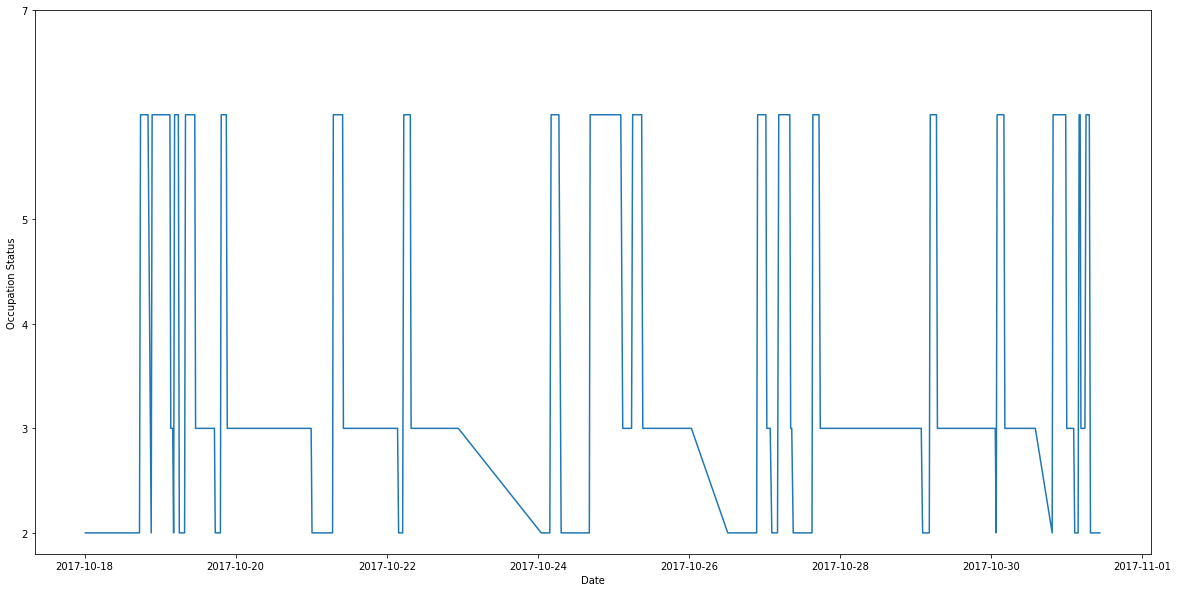

In [312]:
day_lowerBound = 18

occupy_code = [int(data[0]) for data in YinXing_IndustrialPark_sta.pills[0].ult_data if 
          datetime.datetime(2017, 10, day_lowerBound, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=-420, name=None)) < data[2]]
date_code = [data[2] for data in YinXing_IndustrialPark_sta.pills[0].ult_data if 
        datetime.datetime(2017, 10, day_lowerBound, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=-420, name=None)) < data[2]]
print(len(occupy_code))
print(len(date_code))

plt.figure(1, figsize=(20,10))
plt.plot(date_code, occupy_code)
plt.xlabel("Date")
plt.ylabel("Occupation Status")
plt.yticks(np.linspace(2,7,5,dtype=int))
plt.show()

### Operation Power Plot - one single pill

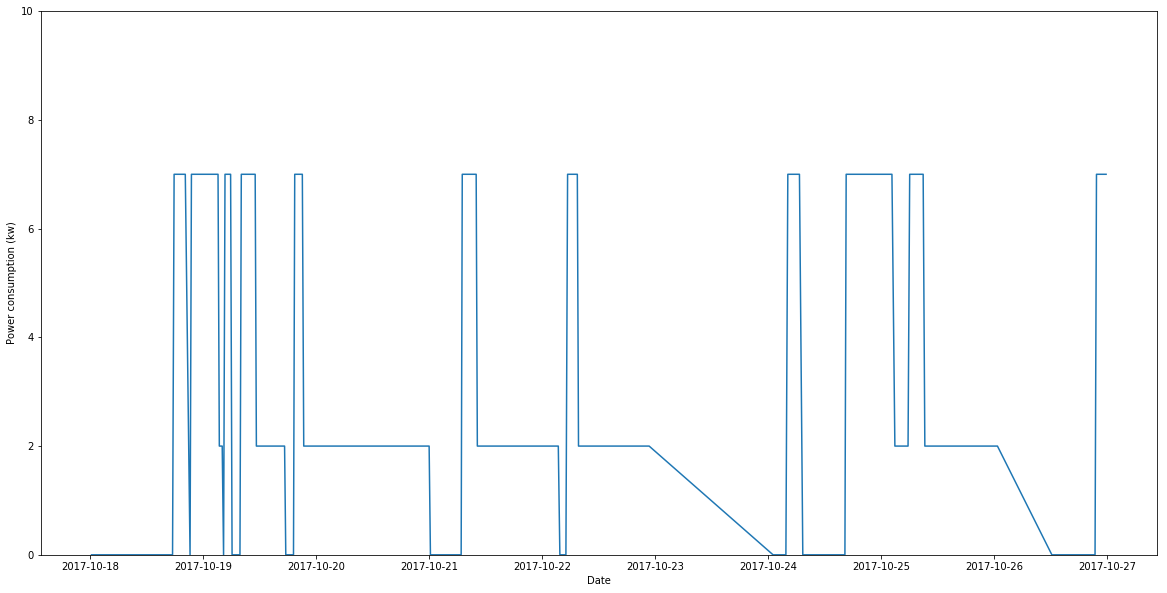

In [316]:
day_lowerBound = 18
day_upperBound = 27

occupy_power_pill = []
power_02 = 0
power_03 = 2
power_06 = 7
date_lowerBound = datetime.datetime(2017, 10, day_lowerBound, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=-420, name=None))
date_upperBound = datetime.datetime(2017, 10, day_upperBound, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=-420, name=None)) 
for data in YinXing_IndustrialPark_sta.pills[0].ult_data:
    if int(data[0]) == 2 and  date_lowerBound < data[2] and date_upperBound > data[2]:
            occupy_power_pill.append(power_02)
    elif int(data[0]) == 3 and date_lowerBound < data[2] and date_upperBound > data[2]:
            occupy_power_pill.append(power_03)
    elif int(data[0]) == 6 and date_lowerBound < data[2] and date_upperBound > data[2]:
            occupy_power_pill.append(power_06)
date_power_pill = [data[2] for data in YinXing_IndustrialPark_sta.pills[0].ult_data if 
        date_lowerBound < data[2] and date_upperBound > data[2]]

plt.figure(2, figsize=(20,10))
plt.plot(date_power_pill, occupy_power_pill)
plt.xlabel("Date")
plt.ylabel("Power consumption (kw)")
plt.ylim((0,10))
plt.show()

### Operation Power Plot - one station

In [317]:
# Check number of data before a time
def check_num_prior(station, date_upperBound):
    length_prior = []
    for pill in station.pills:
        length = 0
        for data in pill.ult_data:
            if data[2] < date_upperBound:
                length+=1
        length_prior.append(length)
    return max(length_prior)
# Check number of data in one period
def check_num_btw(station, date_lowerBound, date_upperBound):
    length_period = []
    for pill in station.pills:
        length = 0
        for data in pill.ult_data:
            if date_lowerBound < data[2] and date_upperBound > data[2]:
                length+=1
        length_period.append(length)
    print("max in between length: ",max(length_period))
    return max(length_period)
# Total utilization data length
def check_num_tot(station):
    length_total = []
    for pill in station.pills:
        length_total.append(len(pill.ult_data))
    return max(length_total)

In [451]:
day_lowerBound = 19
day_upperBound = 21

date_lowerBound = datetime.datetime(2017, 10, day_lowerBound, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=-420, name=None))
date_upperBound = datetime.datetime(2017, 10, day_upperBound, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=-420, name=None))
length_prior = check_num_prior(YinXing_IndustrialPark_sta, date_lowerBound)

# date_lowerBound = datetime.datetime(2017, 10, 18, 12, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=-420, name=None))
# date_upperBound = datetime.datetime(2017, 10, 23, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=-420, name=None))
# length_period = check_num_btw(YinXing_IndustrialPark_sta, date_lowerBound, date_upperBound)

length_total = check_num_tot(YinXing_IndustrialPark_sta)

occupy_power_sta = np.zeros(length_total)
power_02 = 0
#ac charger power
power_ac_03 = 2  #kw
power_ac_06 = 7  #kw
#dc charge power
power_dc_03 = 40 #kw
power_dc_06 = 15 #kw

for pill in YinXing_IndustrialPark_sta.pills:
    for i, data in enumerate(pill.ult_data):
        if int(data[0]) == 2 and  date_lowerBound < data[2] and date_upperBound > data[2]:
            occupy_power_sta[i]+=(power_02)
        elif int(data[0]) == 3 and date_lowerBound < data[2] and date_upperBound > data[2]:
            if len(pill.power) is 0:
                occupy_power_sta[i]+=(power_ac_03)
            else:
                occupy_power_sta[i]+=(power_dc_03)
        elif int(data[0]) == 6 and date_lowerBound < data[2] and date_upperBound > data[2]:
            if len(pill.power) is None:
                occupy_power_sta[i]+=(power_ac_06)
            else:
                occupy_power_sta[i]+=(power_dc_06)
date_power_sta = [data[2] for data in YinXing_IndustrialPark_sta.pills[0].ult_data if 
            date_lowerBound < data[2] and date_upperBound > data[2]]

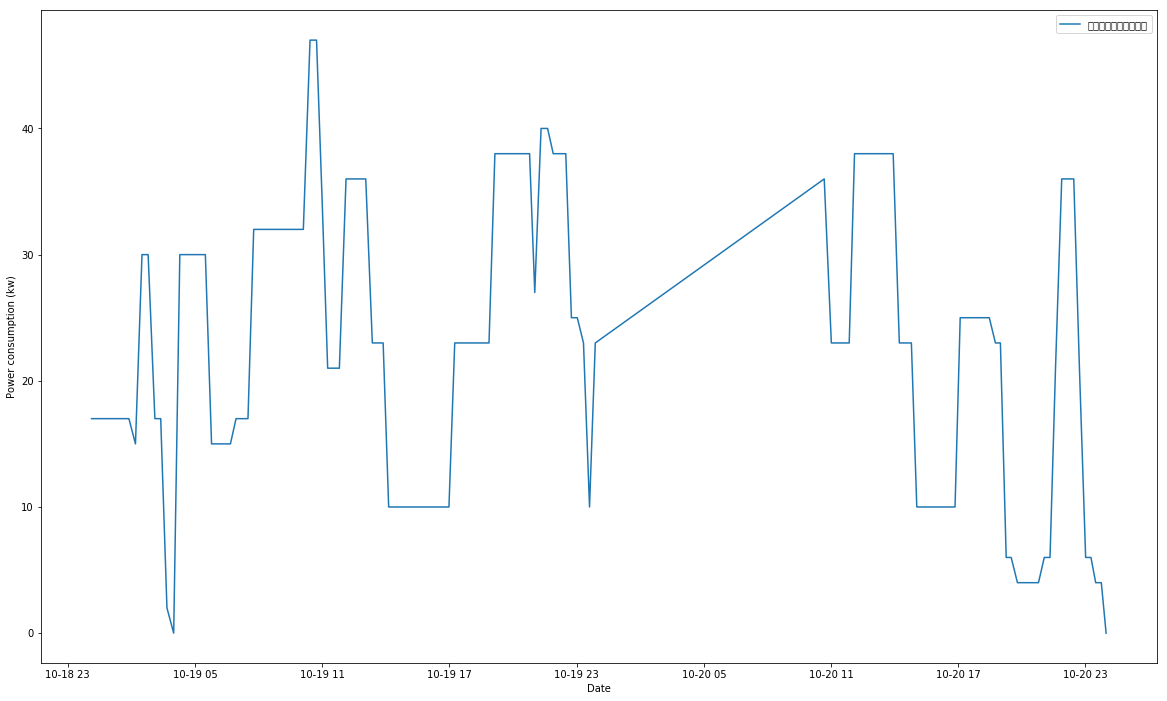

In [452]:
plt.figure(2, figsize=(20,12))
plt.plot(date_power_sta, occupy_power_sta[length_prior:length_prior+len(date_power)], label=YinXing_IndustrialPark_sta.name)
plt.xlabel("Date")
plt.ylabel("Power consumption (kw)")
plt.legend()
plt.show()

### Operation Power Plot - eight stations

In [405]:
day_lowerBound = 10
day_upperBound = 17
date_upperBound = datetime.datetime(2017, 10, day_lowerBound, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=-420, name=None))

occupy_power_sta = [np.zeros(max(length_total_list))]*len(sta_list)

for station in staObject_list:
    length_prior = check_num_prior(station, date_upperBound)
    length_prior_list.append(length_prior)
print("max prior length: ", max(length_prior_list))

length_total_list = []
for station in staObject_list:
    length_total = check_num_tot(station)
    length_total_list.append(length_total)
print("max total length: ", max(length_total_list))


power_02 = 0
#ac charger power
power_ac_03 = 2  #kw
power_ac_06 = 7  #kw
#dc charge power
power_dc_03 = 40 #kw
power_dc_06 = 15 #kw
date_lowerBound = datetime.datetime(2017, 10, day_lowerBound, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=-420, name=None))
date_upperBound = datetime.datetime(2017, 10, day_upperBound, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=-420, name=None))

occupy_power_sta_list = []
date_power_sta_list = []
length_prior_list = []
for counter, station in enumerate(staObject_list):
# for counter in range(1,3):
    length_prior_list.append(check_num_prior(station, date_lowerBound))
    length_total = check_num_tot(station)
    occupy_power_sta = np.zeros(length_total)
    
    for pill in station.pills:
#     for pill in staObject_list[counter].pills:
        for i, data in enumerate(pill.ult_data):
            if int(data[0]) == 2 and date_lowerBound < data[2] and date_upperBound > data[2]:
                occupy_power_sta[i]+=(power_02)
#                 print("counter is ", counter)
#                 print("i is ", i)
#                 print(occupy_power_sta[counter][i])
            elif int(data[0]) == 3 and date_lowerBound < data[2] and date_upperBound > data[2]:
                if len(pill.power) is 0:
                    occupy_power_sta[i]+=(power_ac_03)
                else:
                    occupy_power_sta[i]+=(power_dc_03)
            elif int(data[0]) == 6 and date_lowerBound < data[2] and date_upperBound > data[2]:
                if len(pill.power) is None:
                    occupy_power_sta[i]+=(power_ac_06)
                else:
                    occupy_power_sta[i]+=(power_dc_06)
    occupy_power_sta_list.append(occupy_power_sta)
    date_power_sta = [data[2] for data in station.pills[0].ult_data if 
            date_lowerBound < data[2] and date_upperBound > data[2]]
    date_power_sta_list.append(date_power_sta)

max prior length:  522
max total length:  1828


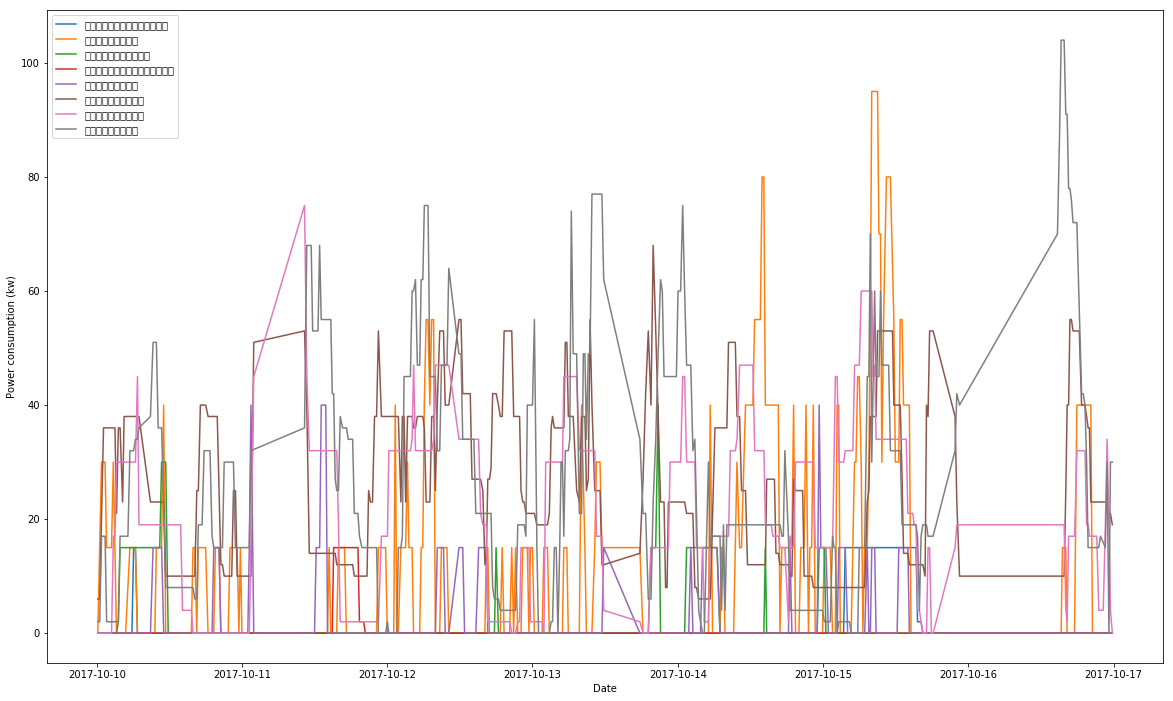

北京航空精密机械研究所充电站


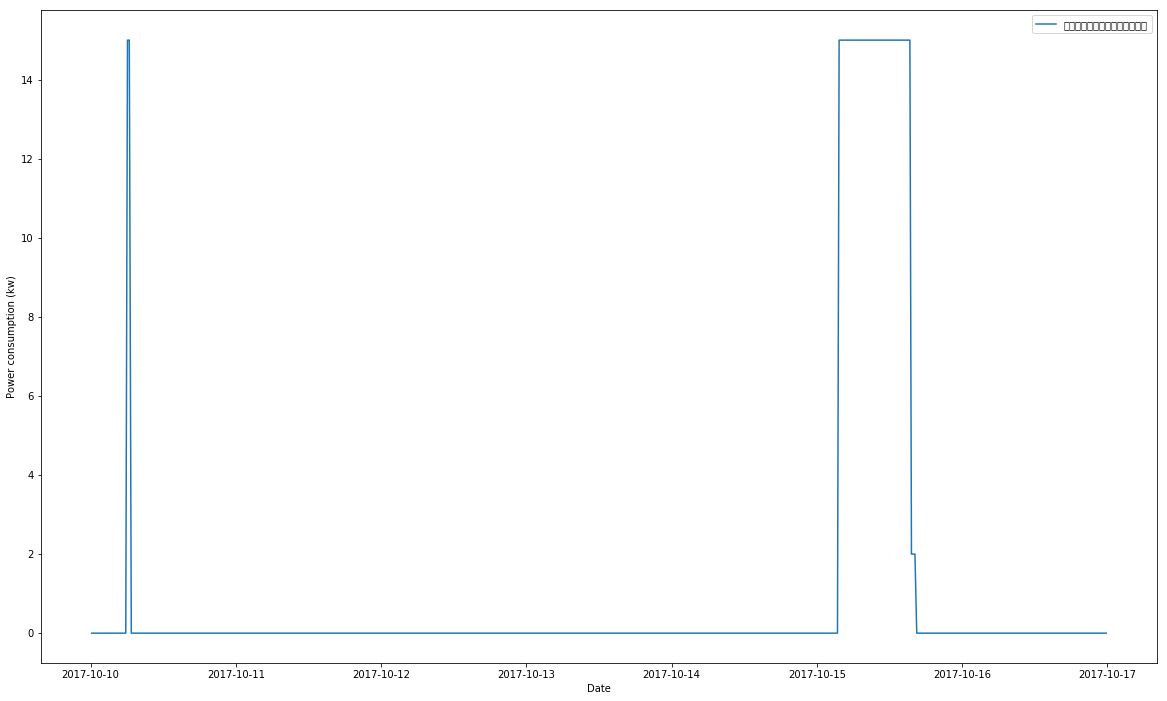

北京西郊宾馆充电站


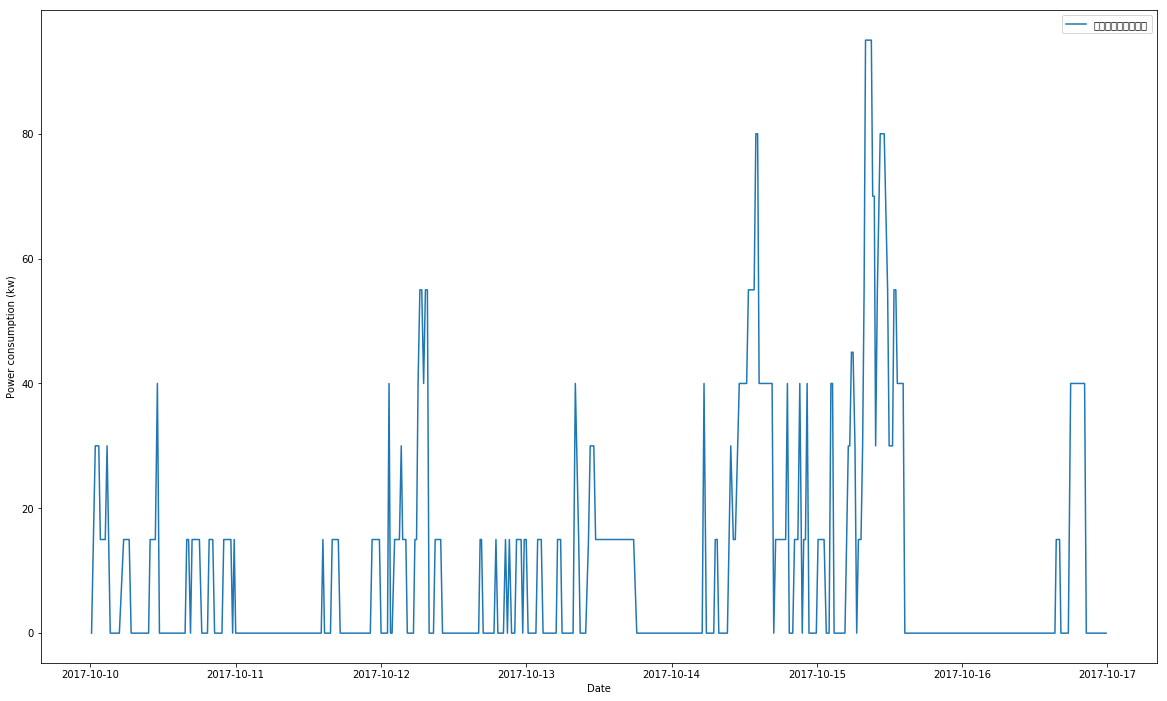

北京阳光丽城酒店充电站


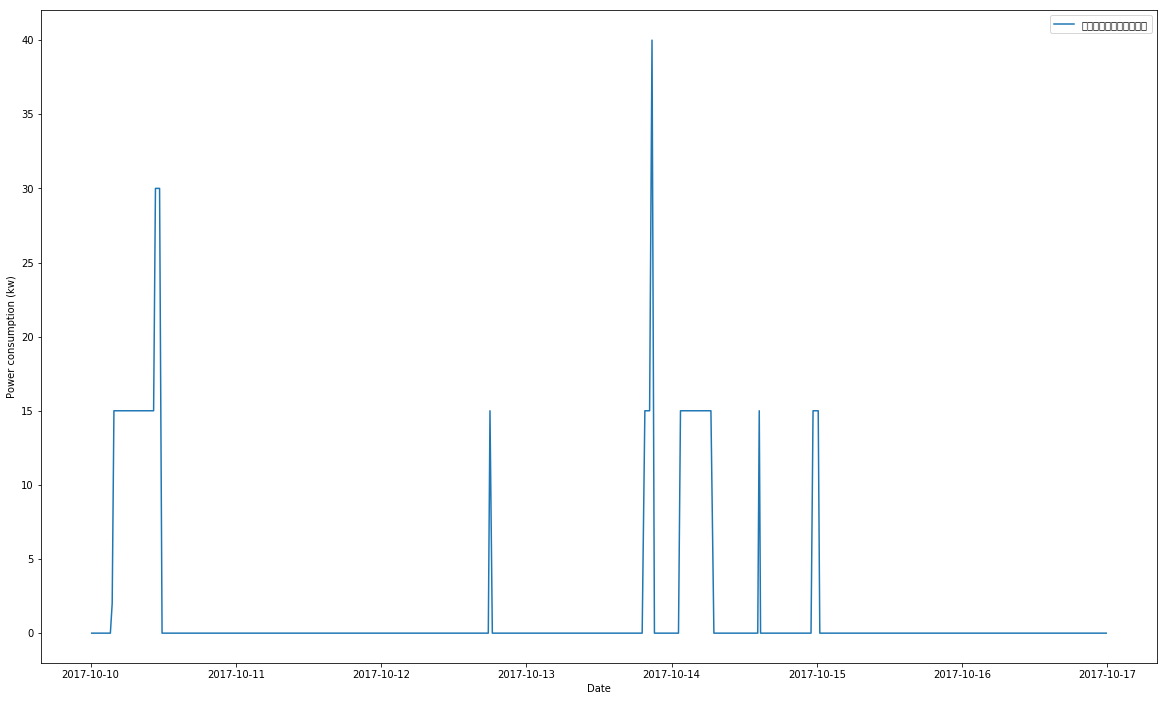

北京元亨苑林山庄有限公司充电站


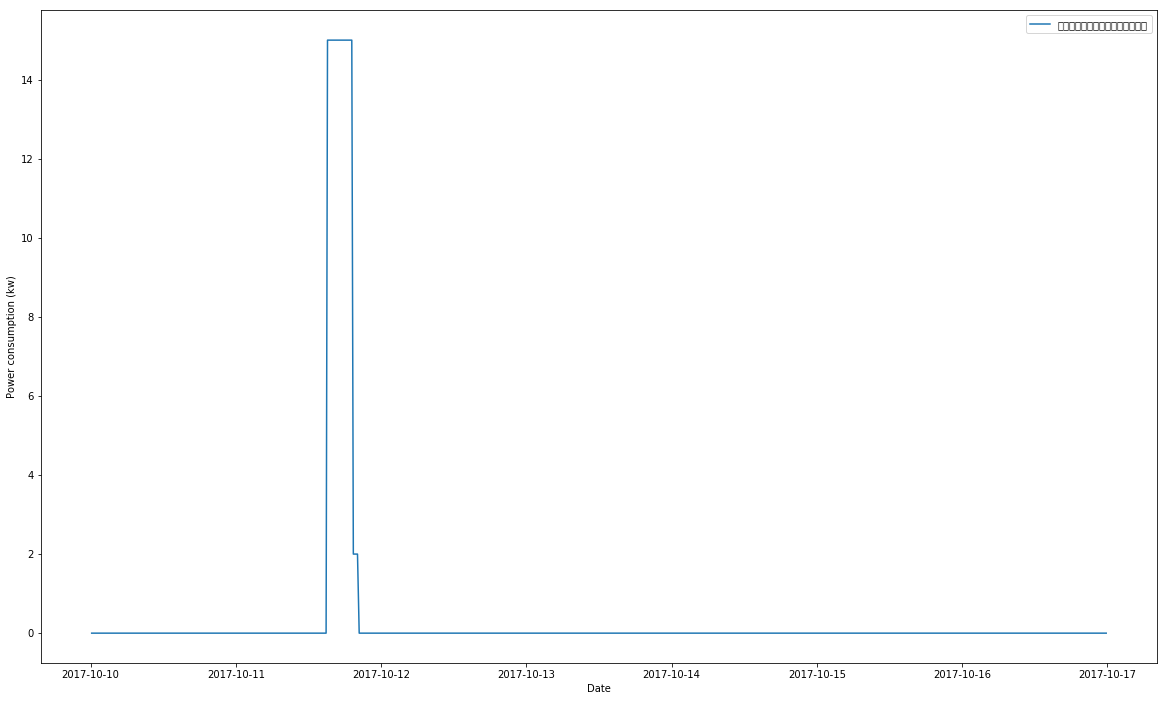

深圳恒江大厦充电站


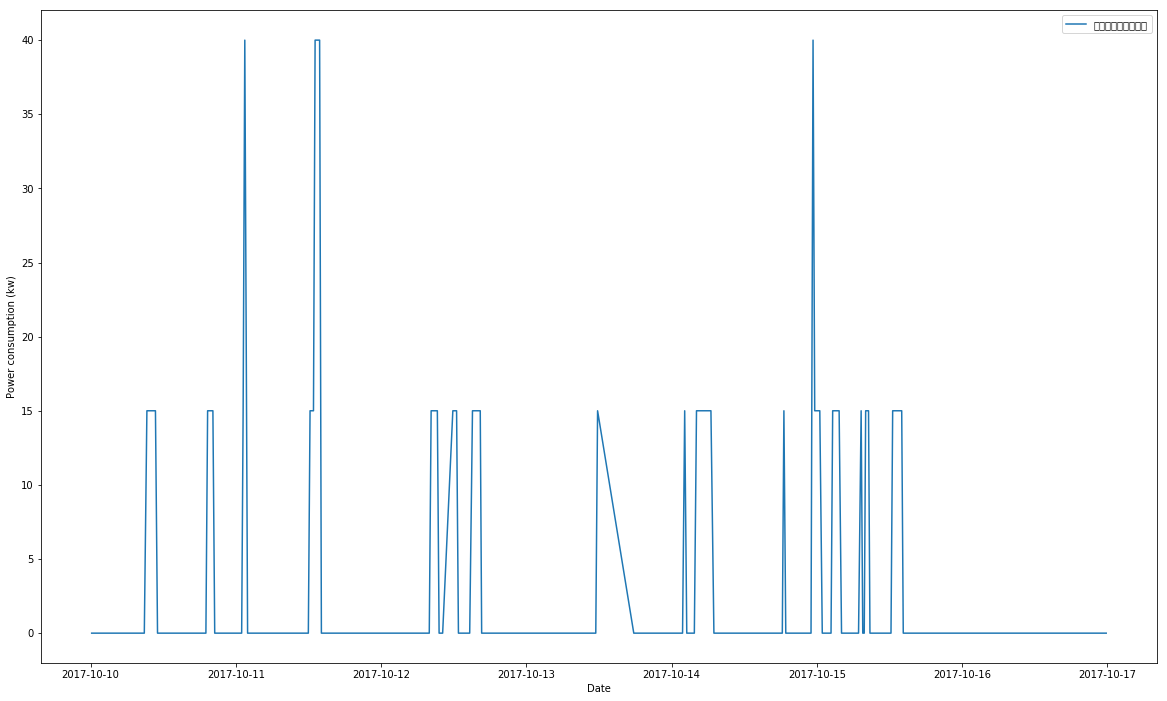

深圳银星工业园充电站


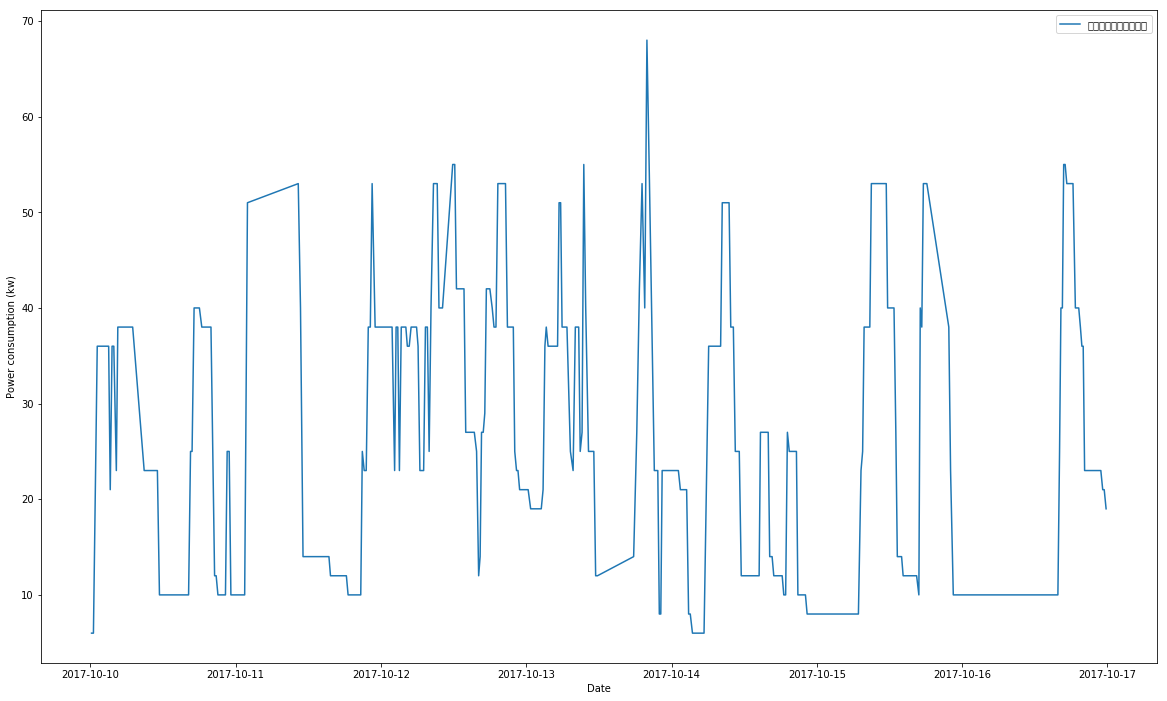

深圳万科九龙山充电站


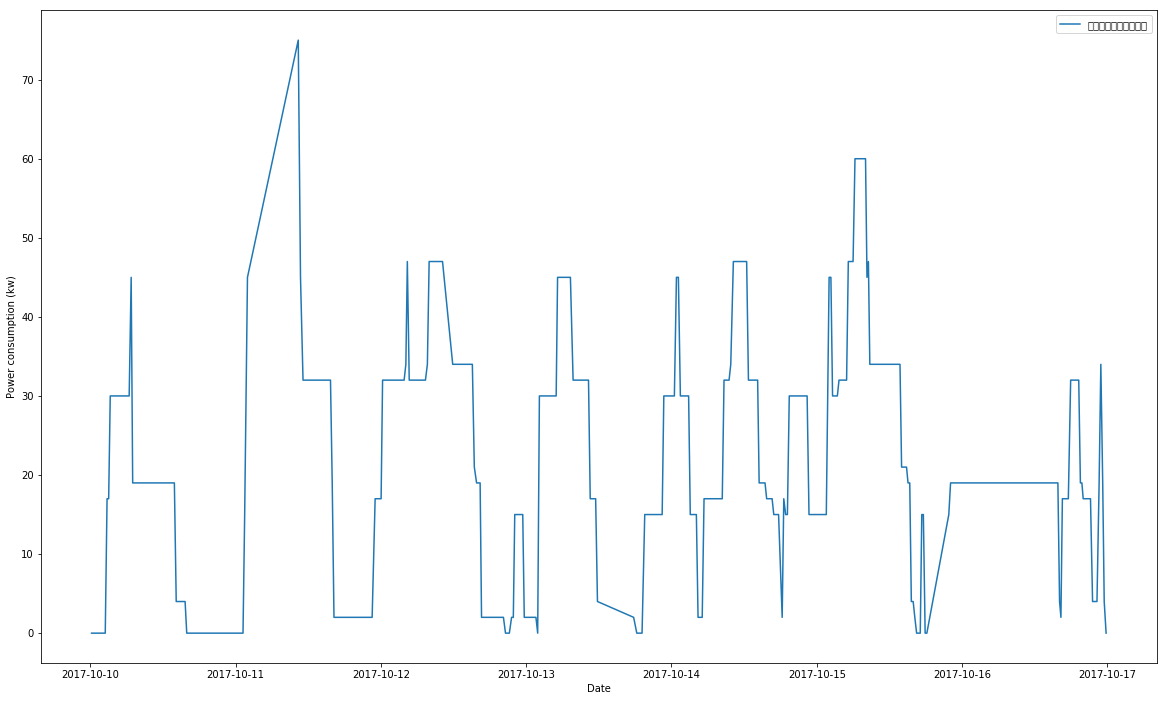

深圳景元大厦充电站


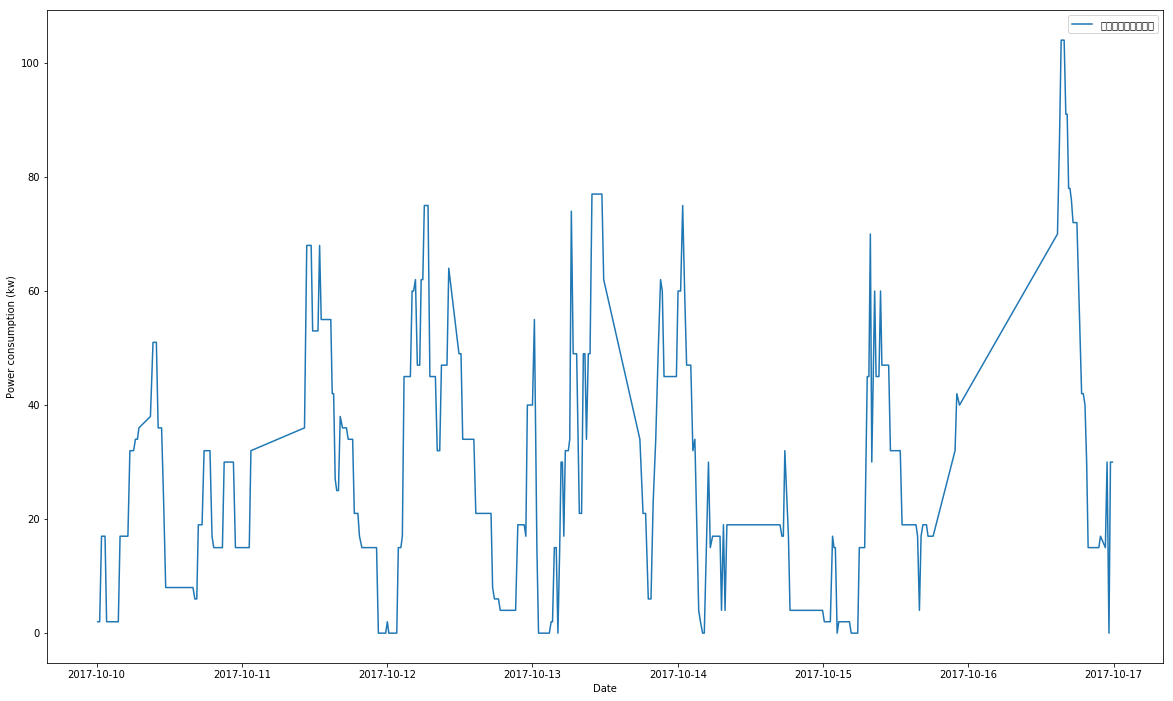

In [406]:
plt.close()
plt.figure(10, figsize=(20,12))
for counter, station in enumerate(staObject_list):
    plt.plot(date_power_sta_list[counter], occupy_power_sta_list[counter][length_prior_list[counter]:length_prior_list[counter]+len(date_power_sta_list[counter])], label=station.name)
plt.xlabel("Date")
plt.ylabel("Power consumption (kw)")
plt.legend()
plt.show()
for counter, station in enumerate(staObject_list):
    plt.figure(counter, figsize=(20,12))
    print(station.name)
    plt.plot(date_power_sta_list[counter], occupy_power_sta_list[counter][length_prior_list[counter]:length_prior_list[counter]+len(date_power_sta_list[counter])], label=station.name)
    plt.xlabel("Date")
    plt.ylabel("Power consumption (kw)")
    plt.legend()
    plt.show()
# plt.show()

### Operation Daily Power Plot - one single station

In [475]:
day_lowerBound = 9
# day_upperBound = 21
occupy_power_sta_list = []
date_power_sta_list = []
length_prior_list = []
for day in range(7):
    day_lowerBound += 1
    day_upperBound = day_lowerBound+1
    date_lowerBound = datetime.datetime(2017, 10, day_lowerBound, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=-420, name=None))
    date_upperBound = datetime.datetime(2017, 10, day_upperBound, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=-420, name=None))
    
    length_prior = check_num_prior(YinXing_IndustrialPark_sta, date_lowerBound)
    length_prior_list.append(length_prior)
    length_total = check_num_tot(YinXing_IndustrialPark_sta)

    occupy_power_sta = np.zeros(length_total)
    power_02 = 0
    #ac charger power
    power_ac_03 = 2  #kw
    power_ac_06 = 7  #kw
    #dc charge power
    power_dc_03 = 40 #kw
    power_dc_06 = 15 #kw
    for pill in YinXing_IndustrialPark_sta.pills:
        for i, data in enumerate(pill.ult_data):
            if int(data[0]) == 2 and  date_lowerBound < data[2] and date_upperBound > data[2]:
                occupy_power_sta[i]+=(power_02)
            elif int(data[0]) == 3 and date_lowerBound < data[2] and date_upperBound > data[2]:
                if len(pill.power) is 0:
                    occupy_power_sta[i]+=(power_ac_03)
                else:
                    occupy_power_sta[i]+=(power_dc_03)
            elif int(data[0]) == 6 and date_lowerBound < data[2] and date_upperBound > data[2]:
                if len(pill.power) is None:
                    occupy_power_sta[i]+=(power_ac_06)
                else:
                    occupy_power_sta[i]+=(power_dc_06)
    occupy_power_sta_list.append(occupy_power_sta)
    date_power_sta = [data[2] for data in YinXing_IndustrialPark_sta.pills[0].ult_data if 
                date_lowerBound < data[2] and date_upperBound > data[2]]
    date_power_sta_list.append(date_power_sta)

In [485]:
day = date_power_sta_list[0][0].day
for i in range(1, len(date_power_sta_list)):
    for j in range(len(date_power_sta_list[i])):
        date_power_sta_list[i][j] = date_power_sta_list[i][j].replace(day=day)

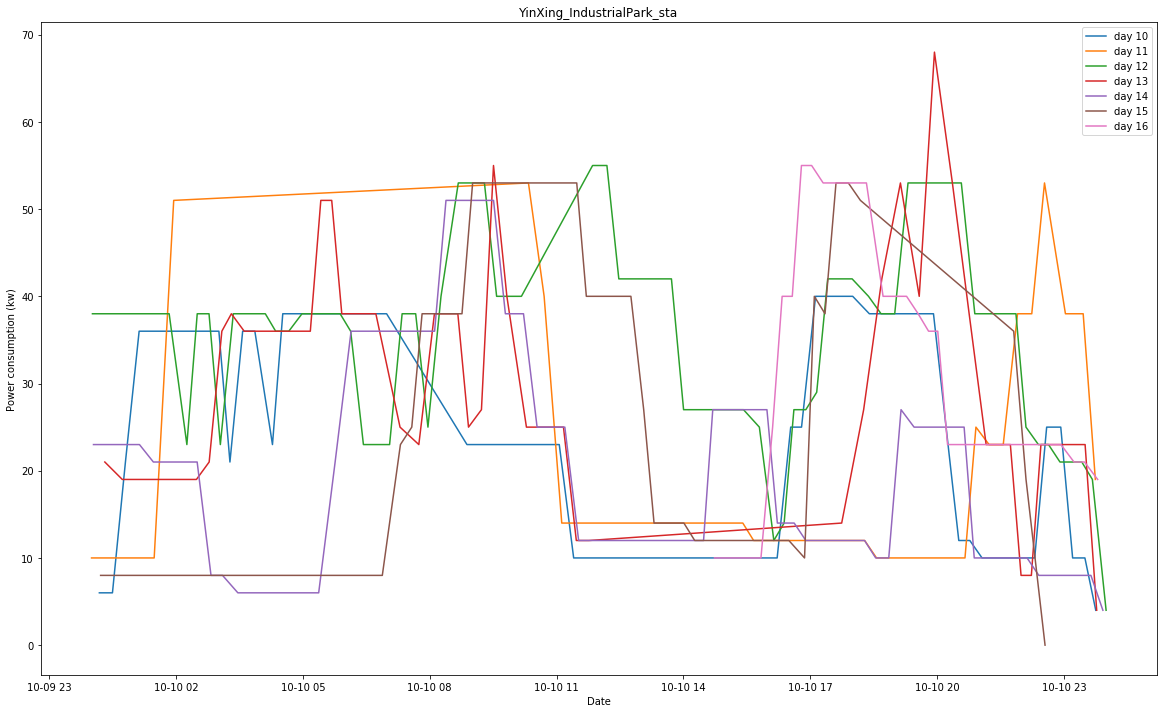

In [494]:
plt.figure(1, figsize=(20,12))
for counter in range(len(occupy_power_sta_list)):
    plt.plot(date_power_sta_list[counter], occupy_power_sta_list[counter][length_prior_list[counter]:length_prior_list[counter]+len(date_power_sta_list[counter])], label="day {}".format(9+counter+1))
plt.xlabel("Date")
plt.ylabel("Power consumption (kw)")
plt.legend()
plt.title("YinXing_IndustrialPark_sta")
plt.show()